### APAN5420 Anomaly Detection - Assignment 8

### Name: Kanyarat Suwannama

* **Section1**: Data Preparation
* **Section2**: Modeling in H2o
* **Section3**: Random Forest Model
* **Section4**: Under Sampling
* **Section5**: Model Implementation with FE
* **Section6**: Conclusion

# Section 1: Data preparation

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Use Pandas to do data preparation

In [2]:
data = pd.read_csv("XYZloan_default_selected_vars.csv")

### This is description

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     data, test_size=0.40, random_state=42)

In [4]:
train.shape

(48000, 89)

In [5]:
var = pd.DataFrame(train.dtypes)
var.head(10)

,0
Unnamed: 0.1,int64
Unnamed: 0,int64
id,int64
loan_default,int64
AP001,int64
AP002,int64
AP003,int64
AP004,int64
AP005,object
AP006,object


In [6]:
var = pd.DataFrame(train.dtypes).reset_index()
var.head()

,index,0
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64


In [7]:
var.columns = ['varname','dtype'] 
var.head(10)

,varname,dtype
0,Unnamed: 0.1,int64
1,Unnamed: 0,int64
2,id,int64
3,loan_default,int64
4,AP001,int64
5,AP002,int64
6,AP003,int64
7,AP004,int64
8,AP005,object
9,AP006,object


In [8]:
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [9]:
var['source'].value_counts()

CD    36
TD    24
AP     9
CR     8
PA     6
Un     2
MB     2
id     1
lo     1
Name: source, dtype: int64

In [10]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [11]:
train['loan_default'].value_counts(dropna=False)

0    38736
1     9264
Name: loan_default, dtype: int64

# Section 3: H2O

H2O has proven to be one of the favorite tools of many data scientists. It streamlines modeling development and production and can produce models that can be run in other languages such as Java.

In [12]:
#pip install h2o

In [13]:
import h2o

In [14]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,21 hours 53 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.2
H2O_cluster_version_age:,12 days
H2O_cluster_name:,H2O_from_python_kanyaratsuwannama_4dlj2u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.306 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [15]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [16]:
target='loan_default'

In [17]:
predictors = ['AP001','AP003','AP008','CR009', 'CR015', 'CR019','PA022', 'PA023', 'PA029',
             'TD001', 'TD005', 'TD006', 'TD009', 'TD010', 'TD014']

# Section 3: H20 Random Forest Model

The random forest technique draws some samples to build a model, draws some samples again to build another model, and so on. All of these sampling and modeling is done independently and simultaneously. The outcome is the average of the predicted values of all the models. The classification from each H2O tree can be thought of as a vote; the most votes determines the classification.

In [18]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [19]:
rf_v1 = H2ORandomForestEstimator(
        model_id = 'rf_v1',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v1.train(predictors,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v1


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         101141                 5            12           7.22333       19            26            21.96

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14802859805102037
RMSE: 0.3847448479850255
MAE: 0.29669557184219936
RMSLE: 0.2697362514448506
Mean Residual Deviance: 0.14802859805102037

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.1481988568929225
RMSE: 0.38496604641568394
MAE: 0.29704432972637906
RMSLE: 0.26991454423770994
Mean Residual Deviance: 0.1481988568929225

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.29693    0.0108357   0.290922      0.290155      0.301573      0.300761      0.294449      0.315453      0.285167      0.300547      0.28045       0.309821
mean_residual_deviance  0.148027   0.0122421   0.141315      0.142118      0.153636      0.153613      0.145292      0.168777      0.133157      0.14977       0.129896      0.162698
mse                     0.148027   0.0122421   0.141315      0.142118      0.153636      0.153613      0.145292      0.168777      0.133157      0.14977       0.129896      0.162698
r2                      0.0262142  0.0156354   0.00623724    0.0353978     0.0311223     0.0340365     0.0556708     0.0201881     0.00882133    0.0088188     0.0371699     0.0246793
residual_deviance       0.148027   0.0122421   0.141315      0.142118      0.153636      0.153613      0.145292      0.168777      0.133157      0.14977       0.129896      0.162698
rmse                    0.384448   0.0158859   0.375919      0.376986      0.391965      0.391935      0.381172      0.410825      0.364907      0.387001      0.360411      0.403358
rmsle                   0.269692   0.00850238  0.266201      0.264839      0.273434      0.272981      0.266553      0.283907      0.260424      0.272572      0.256208      0.279798

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-03-22 10:10:19  10.900 sec  0.0                nan                  nan                  nan
     2023-03-22 10:10:19  10.905 sec  1.0                0.39209601295539326  0.2967295939244745   0.15373928337551593
     2023-03-22 10:10:19  10.907 sec  2.0                0.39485681206406026  0.298683924108267    0.15591190203339259
     2023-03-22 10:10:19  10.910 sec  3.0                0.3900608901430799   0.29546714716573524  0.15214749801921185
     2023-03-22 10:10:19  10.913 sec  4.0                0.3890885914884359   0.2951576773978585   0.15138993202645495
     2023-03-22 10:10:19  10.916 sec  5.0                0.38873117039142535  0.296323100393795    0.15111192283388739
     2023-03-22 10:10:19  10.919 sec  6.0                0.3881215997929998   0.2969176449977721   0.15063837622587753
     2023-03-22 10:10:19  10.921 sec  7.0                0.3869908209064193   0.29616463623024347  0.14976189546582427
     2023-03-22 10:10:19  10.924 sec  8.0                0.38610971312376946  0.29532794902166565  0.14908071056851954
     2023-03

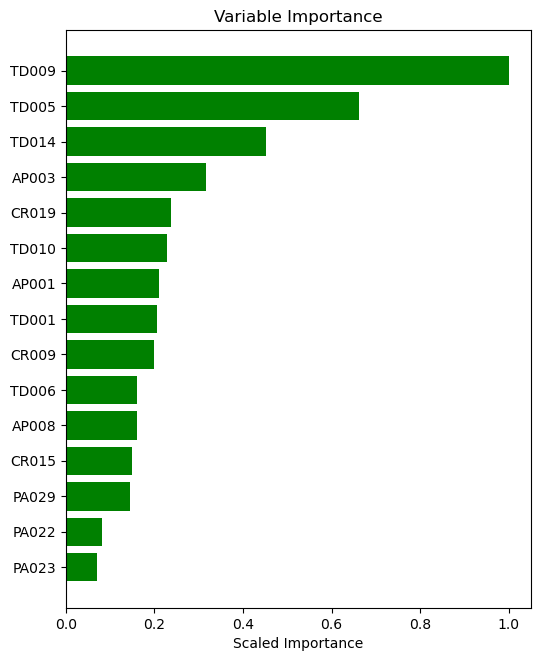

In [20]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
VarImp(rf_v1)

In [21]:
predictions = rf_v1.predict(test_hex)
predictions.head()
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,loan_default,predict
0,0,0.285100
1,0,0.155463
2,0,0.135238
3,0,0.132794
4,0,0.106016


In [22]:
# Cumulative lift
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(rf_v1)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,99,221,320,99,221,0.16,0.08,60.0,1.65,8.0,30.94
1,320,90,230,640,189,451,0.32,0.17,120.0,1.58,15.0,29.53
2,320,76,244,960,265,695,0.44,0.27,180.0,1.47,17.0,27.60
3,320,68,252,1280,333,947,0.56,0.36,240.0,1.39,20.0,26.02
4,320,70,250,1600,403,1197,0.67,0.46,300.0,1.34,21.0,25.19
5,320,48,272,1920,451,1469,0.75,0.56,360.0,1.25,19.0,23.49
6,320,47,273,2240,498,1742,0.83,0.67,420.0,1.19,16.0,22.23
7,320,38,282,2560,536,2024,0.89,0.78,480.0,1.12,11.0,20.94
8,320,29,291,2880,565,2315,0.94,0.89,540.0,1.05,5.0,19.62


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


<AxesSubplot:xlabel='decile'>

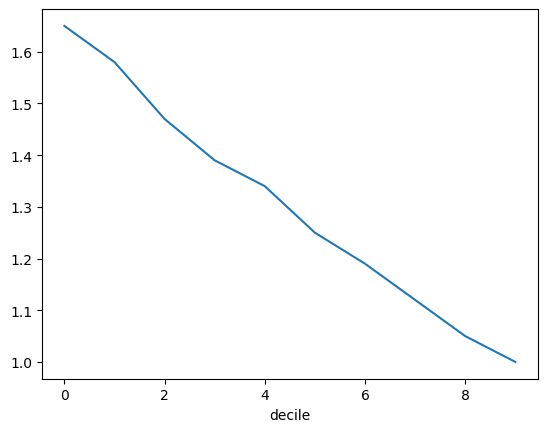

In [23]:
gains = createGains(rf_v1)
gains['lift'].plot.line()

In [24]:
# ROC Curve
def ROC_AUC(my_result,df,target):
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt

    # ROC
    y_actual = df[target].as_data_frame()
    y_pred = my_result.predict(df).as_data_frame()
    fpr = list()
    tpr = list()
    roc_auc = list()
    fpr,tpr,_ = roc_curve(y_actual,y_pred)
    roc_auc = auc(fpr,tpr)
    
    # Precision-Recall
    average_precision = average_precision_score(y_actual,y_pred)

    print('')
    print('   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate')
    print('')
    print('	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy')
    print('')
    print('   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)')
    print('')
    
    # plotting
    plt.figure(figsize=(10,4))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,color='darkorange',lw=2,label='ROC curve (aare=%0.2f)' % roc_auc)
    plt.plot([0,1],[0,1],color='navy',lw=3,linestyle='--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: AUC={0:0.4f}'.format(roc_auc))
    plt.legend(loc='lower right')

    # Precision-Recall
    plt.subplot(1,2,2)
    precision,recall,_ = precision_recall_curve(y_actual,y_pred)
    plt.step(recall,precision,color='b',alpha=0.2,where='post')
    plt.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0,1.05])
    plt.xlim([0.0,1.0])
    plt.title('Precision-Recall curve: PR={0:0.4f}'.format(average_precision))
    plt.show()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



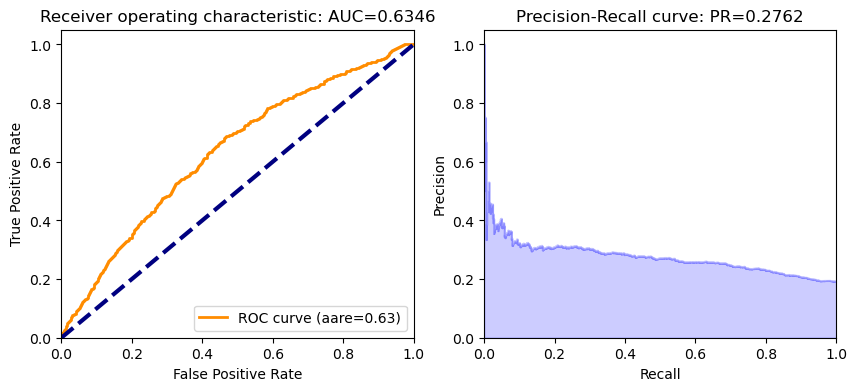

In [25]:
ROC_AUC(rf_v1,test_hex,'loan_default')

# Section 4: Undersampling

Undersampling is a technique to balance uneven datasets by keeping all of the data in the minority class and decreasing the size of the majority class. It is one of several techniques data scientists can use to extract more accurate information from originally imbalanced datasets. Though it has disadvantages, such as the loss of potentially important information, it remains a common and important skill for data scientists. 

In [26]:
#pip install imblearn

In [27]:
from collections import Counter
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)

In [28]:
predictors = ['AP001','AP003','AP008','CR009', 'CR015', 'CR019','PA022', 'PA023', 'PA029',
             'TD001', 'TD005', 'TD006', 'TD009', 'TD010', 'TD014']
target='loan_default'

### RandomUnderSampler

A simple under-sampling technique is to under-sample the majority class randomly and uniformly. This can potentially lead to the loss of information. But if the examples of the majority class are near to others, this method might yield good results.

In [29]:
y_train = train['loan_default']
y_test = test['loan_default']
x_train = train[predictors]
x_test = test[predictors]

In [30]:
# RandomUnderSampler
under = RandomUnderSampler(random_state=0, sampling_strategy='auto') 
X_rus, y_rus = under.fit_resample(x_train, y_train)
print('Random undersampling {}'.format(Counter(y_rus)))

Random undersampling Counter({0: 9264, 1: 9264})


In [31]:
smpl_rus = pd.concat([X_rus,y_rus], axis=1)
smpl_hex_rus = h2o.H2OFrame(smpl_rus)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [32]:
rf_v2 = H2ORandomForestEstimator(
        model_id = 'rf_v2',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v2.train(predictors,target,training_frame=smpl_hex_rus)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         336226                 9            14           11.2167       78            92            84.1367

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.23425125048726414
RMSE: 0.4839950934537086
MAE: 0.4715810556140376
RMSLE: 0.3402215676784756
Mean Residual Deviance: 0.23425125048726414

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.23437939927298834
RMSE: 0.48412746180421157
MAE: 0.47192831283928616
RMSLE: 0.3403206928033787
Mean Residual Deviance: 0.23437939927298834

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.471906   0.002518    0.467504      0.475118      0.472886      0.476325      0.470213      0.471051      0.470575      0.472765      0.471132      0.471492
mean_residual_deviance  0.234358   0.00259174  0.230391      0.238279      0.235463      0.238631      0.232184      0.233658      0.23292       0.235138      0.233044      0.233869
mse                     0.234358   0.00259174  0.230391      0.238279      0.235463      0.238631      0.232184      0.233658      0.23292       0.235138      0.233044      0.233869
r2                      0.0610423  0.0103955   0.0784141     0.0440216     0.0578293     0.0446809     0.0653208     0.0641453     0.0680814     0.0594487     0.0653827     0.0630978
residual_deviance       0.234358   0.00259174  0.230391      0.238279      0.235463      0.238631      0.232184      0.233658      0.23292       0.235138      0.233044      0.233869
rmse                    0.484098   0.00267402  0.47999       0.488139      0.485245      0.488499      0.481855      0.483382      0.482618      0.48491       0.482746      0.4836
rmsle                   0.340305   0.00348925  0.338273      0.34662       0.341592      0.341294      0.333789      0.341966      0.33783       0.341284      0.342505      0.337899

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-03-22 10:10:49  24.764 sec  0.0                nan                  nan                  nan
     2023-03-22 10:10:49  24.773 sec  1.0                0.48962117755804113  0.4709496100588183   0.23972889751332285
     2023-03-22 10:10:49  24.780 sec  2.0                0.4906141936621191   0.47227231395072145  0.2407022870227313
     2023-03-22 10:10:49  24.786 sec  3.0                0.48916365933244693  0.4715227723325108   0.23928108561151018
     2023-03-22 10:10:49  24.792 sec  4.0                0.48898537385734436  0.4719532040043101   0.2391066958464068
     2023-03-22 10:10:49  24.799 sec  5.0                0.48825295879036607  0.47170458641251795  0.2383909517675469
     2023-03-22 10:10:49  24.806 sec  6.0                0.48788082955034506  0.47172367097031537  0.23802770384273286
     2023-03-22 10:10:49  24.815 sec  7.0                0.4874355559143769   0.47174140103609374  0.23759342116955762
     2023-03-22 10:10:49  24.827 sec  8.0                0.48681968997004743  0.4712574207052972   0.23699341054253312
     2023-03-22

In [33]:
createGains(rf_v2)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,107,213,320,107,213,0.18,0.08,60.0,1.78,10.0,33.44
1,320,88,232,640,195,445,0.32,0.17,120.0,1.62,15.0,30.47
2,320,67,253,960,262,698,0.44,0.27,180.0,1.46,17.0,27.29
3,320,81,239,1280,343,937,0.57,0.36,240.0,1.43,21.0,26.80
4,320,57,263,1600,400,1200,0.67,0.46,300.0,1.33,21.0,25.00
5,320,61,259,1920,461,1459,0.77,0.56,360.0,1.28,21.0,24.01
6,320,49,271,2240,510,1730,0.85,0.67,420.0,1.21,18.0,22.77
7,320,45,275,2560,555,2005,0.92,0.77,480.0,1.16,15.0,21.68
8,320,29,291,2880,584,2296,0.97,0.88,540.0,1.08,9.0,20.28


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


<AxesSubplot:xlabel='decile'>

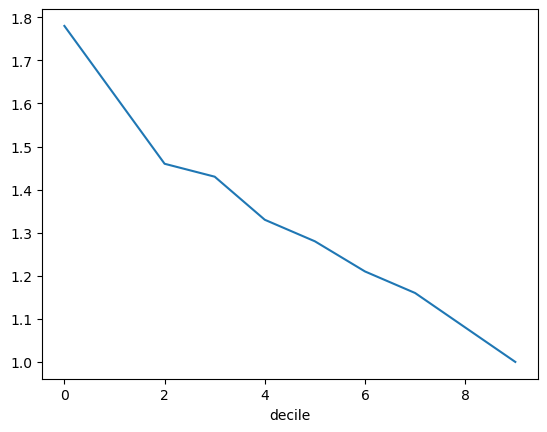

In [34]:
gains = createGains(rf_v2)
gains['lift'].plot.line()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



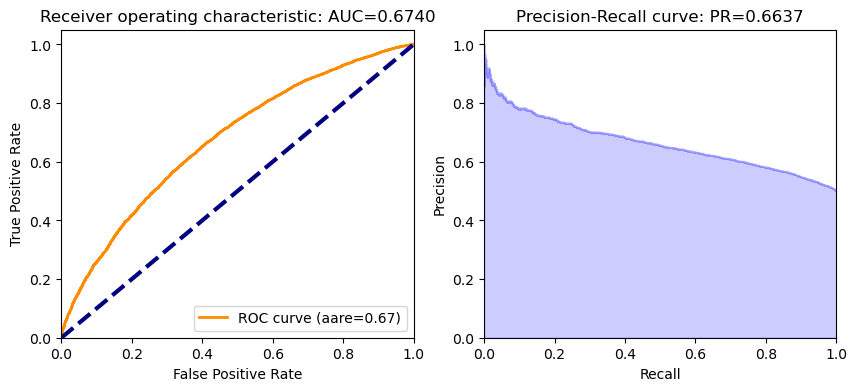

In [35]:
# Check the ROC
ROC_AUC(rf_v2,smpl_hex_rus,'loan_default')

### ClusterCentroids

This method undersamples the majority class by replacing a cluster of majority samples. This method finds the clusters of the majority class with K-mean algorithms. Then it keeps the cluster centroids of the N clusters as the new majority samples.

In [36]:
# ClusterCentroids
sampler = ClusterCentroids(random_state=0, sampling_strategy='auto') 
X_rus, y_rus = under.fit_resample(x_train, y_train)
print('Cluster centriods undersampling {}'.format(Counter(y_rus)))

Cluster centriods undersampling Counter({0: 9264, 1: 9264})


In [37]:
smpl_rus = pd.concat([X_rus,y_rus], axis=1)

In [38]:
smpl_hex_rus = h2o.H2OFrame(smpl_rus)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [39]:
rf_v3 = H2ORandomForestEstimator(
        model_id = 'rf_v3',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v3.train(predictors,target,training_frame=smpl_hex_rus)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v3


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         336222                 9            14           11.2167       78            92            84.1367

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.23425125048726414
RMSE: 0.4839950934537086
MAE: 0.4715810556140376
RMSLE: 0.3402215676784756
Mean Residual Deviance: 0.23425125048726414

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.23437939927298834
RMSE: 0.48412746180421157
MAE: 0.47192831283928616
RMSLE: 0.3403206928033787
Mean Residual Deviance: 0.23437939927298834

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.471906   0.002518    0.467504      0.475118      0.472886      0.476325      0.470213      0.471051      0.470575      0.472765      0.471132      0.471492
mean_residual_deviance  0.234358   0.00259174  0.230391      0.238279      0.235463      0.238631      0.232184      0.233658      0.23292       0.235138      0.233044      0.233869
mse                     0.234358   0.00259174  0.230391      0.238279      0.235463      0.238631      0.232184      0.233658      0.23292       0.235138      0.233044      0.233869
r2                      0.0610423  0.0103955   0.0784141     0.0440216     0.0578293     0.0446809     0.0653208     0.0641453     0.0680814     0.0594487     0.0653827     0.0630978
residual_deviance       0.234358   0.00259174  0.230391      0.238279      0.235463      0.238631      0.232184      0.233658      0.23292       0.235138      0.233044      0.233869
rmse                    0.484098   0.00267402  0.47999       0.488139      0.485245      0.488499      0.481855      0.483382      0.482618      0.48491       0.482746      0.4836
rmsle                   0.340305   0.00348925  0.338273      0.34662       0.341592      0.341294      0.333789      0.341966      0.33783       0.341284      0.342505      0.337899

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-03-22 10:11:22  26.091 sec  0.0                nan                  nan                  nan
     2023-03-22 10:11:22  26.101 sec  1.0                0.48962117755804113  0.4709496100588183   0.23972889751332285
     2023-03-22 10:11:22  26.111 sec  2.0                0.4906141936621191   0.47227231395072145  0.2407022870227313
     2023-03-22 10:11:22  26.121 sec  3.0                0.48916365933244693  0.4715227723325108   0.23928108561151018
     2023-03-22 10:11:22  26.130 sec  4.0                0.48898537385734436  0.4719532040043101   0.2391066958464068
     2023-03-22 10:11:22  26.139 sec  5.0                0.48825295879036607  0.47170458641251795  0.2383909517675469
     2023-03-22 10:11:22  26.148 sec  6.0                0.48788082955034506  0.47172367097031537  0.23802770384273286
     2023-03-22 10:11:22  26.161 sec  7.0                0.4874355559143769   0.47174140103609374  0.23759342116955762
     2023-03-22 10:11:22  26.170 sec  8.0                0.48681968997004743  0.4712574207052972   0.23699341054253312
     2023-03-22

In [40]:
# check the lift
createGains(rf_v3)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,107,213,320,107,213,0.18,0.08,60.0,1.78,10.0,33.44
1,320,88,232,640,195,445,0.32,0.17,120.0,1.62,15.0,30.47
2,320,67,253,960,262,698,0.44,0.27,180.0,1.46,17.0,27.29
3,320,81,239,1280,343,937,0.57,0.36,240.0,1.43,21.0,26.80
4,320,57,263,1600,400,1200,0.67,0.46,300.0,1.33,21.0,25.00
5,320,61,259,1920,461,1459,0.77,0.56,360.0,1.28,21.0,24.01
6,320,49,271,2240,510,1730,0.85,0.67,420.0,1.21,18.0,22.77
7,320,45,275,2560,555,2005,0.92,0.77,480.0,1.16,15.0,21.68
8,320,29,291,2880,584,2296,0.97,0.88,540.0,1.08,9.0,20.28


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


<AxesSubplot:xlabel='decile'>

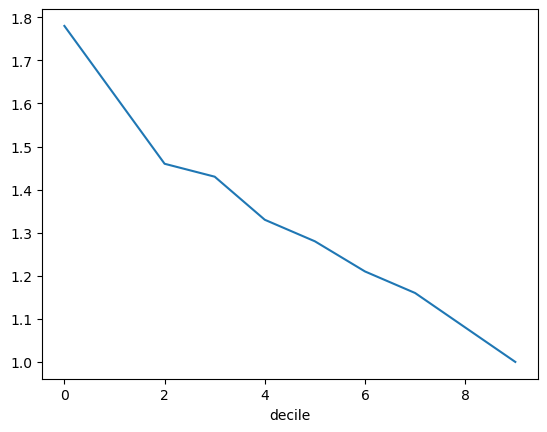

In [41]:
gains = createGains(rf_v3)
gains['lift'].plot.line()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



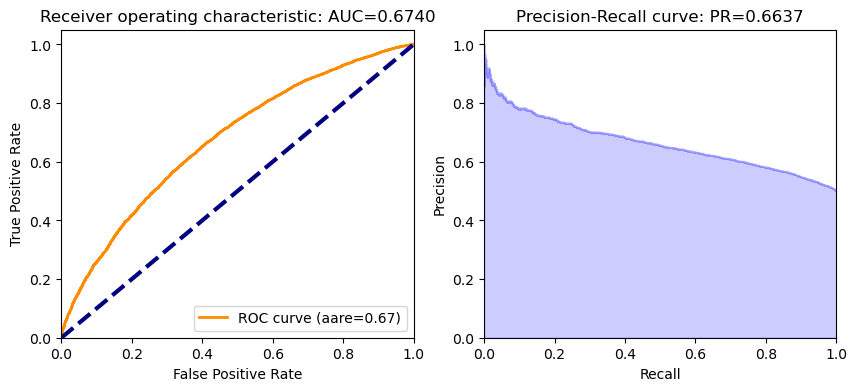

In [42]:
# Check the ROC
ROC_AUC(rf_v3,smpl_hex_rus,'loan_default')

# Section 5: Model with FE Implementation 

### Bin the train and test dataset

In [43]:
features = ['loan_default','AP001', 'AP003', 'AP008', 'CR009', 'CR015', 'CR019', 'PA022', 'PA023', 'PA029', 'TD001', 'TD005', 'TD006', 'TD009', 'TD010', 'TD014']
df = data[features]

In [44]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values_per = (df.isnull().sum() / df.isnull().count())
pd.concat([missing_values, missing_values_per],axis=1, keys = ['Count_of_Missing','Percentage'])

,Count_of_Missing,Percentage
loan_default,0,0.000000
AP001,0,0.000000
AP003,0,0.000000
AP008,0,0.000000
CR009,0,0.000000
CR015,0,0.000000
CR019,0,0.000000
PA022,381,0.004763
PA023,381,0.004763
PA029,381,0.004763


In [45]:
r = pd.concat([missing_values, missing_values_per],axis=1, keys = ['Count_of_Missing','Percentage']).reset_index()
r

,index,Count_of_Missing,Percentage
0,loan_default,0,0.000000
1,AP001,0,0.000000
2,AP003,0,0.000000
3,AP008,0,0.000000
4,CR009,0,0.000000
5,CR015,0,0.000000
6,CR019,0,0.000000
7,PA022,381,0.004763
8,PA023,381,0.004763
9,PA029,381,0.004763


In [46]:
def null_cell(df):
    dfx = df.copy()
    missing_values = dfx.isnull().sum()
    missing_values_per = dfx.isnull().sum() / dfx.isnull().count()
    null_values = pd.concat([missing_values, missing_values_per],axis=1, keys = ['the_null','the_null_perc'])
    null_values = null_values.sort_values('the_null',ascending=False)
    return null_values[null_values['the_null']>0]

fill_list = (null_cell(df)).index
fill_list

Index(['PA022', 'PA023', 'PA029'], dtype='object')

In [47]:
r.loc[r['index']=='type','Percentage']

Series([], Name: Percentage, dtype: float64)

In [48]:
df_mean = df # Do you know this is different from "df_mean = df.copy()?"" This just point to the same data frame. It does not create a copy.
df_mean = df.copy() # Here create a physical copy of df.

In [49]:
for col in fill_list:
    df_mean.loc[:,col].fillna(df_mean.loc[:,col].mean(),inplace=True)

In [50]:
predictors = ['AP001','AP003','AP008','CR009', 'CR015', 'CR019','PA022', 'PA023', 'PA029',
             'TD001', 'TD005', 'TD006', 'TD009', 'TD010', 'TD014']

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_mean[predictors],
                                                    df_mean['loan_default'], 
                                                    random_state=0)

In [52]:
train = pd.concat([X_train, Y_train], axis=1)
len(train)

60000

In [53]:
test = pd.concat([X_test, Y_test], axis=1)
len(test)

20000

### Binning the train and test dataset

In [54]:
def binning(var, train, test):
    # Define the extreme values 
    extreme_val = [-99,-98,-1]
    
    # Fit the extreme values into single category
    train.loc[train[var]==-99, var+'_bin']=-99
    train.loc[train[var]==-1, var+'_bin']=-1
    train.loc[train[var]==-98, var+'_bin']=-98
    
    # Separate the dataset into two parts based on whether the values of a variable are in a list of extreme values
    special_train = train.loc[train[var].isin(extreme_val)]
    normal_train = train.loc[-train[var].isin(extreme_val)]
    
    # Transfer the continuous variable to categorical binned variables 
    s, b = pd.qcut(normal_train[var], 10, duplicates='drop', retbins=True)

    normal_train[var+'_bin'] = pd.cut(normal_train[var], bins=b, duplicates='drop').astype(str)
    
    # Recombine the data
    train=pd.concat([special_train, normal_train], axis=0)
    
    # Put the extreme value in specific categories
    test.loc[test[var]==-99, var+'_bin']=-99
    test.loc[test[var]==-1, var+'_bin']=-1
    test.loc[test[var]==-98, var+'_bin']=-98
    
    # Separate the dataset into two parts based on whether the values of a variable are in a list of extreme values
    special_test = test.loc[test[var].isin(extreme_val)]
    normal_test = test.loc[-test[var].isin(extreme_val)]
    
    # Use the binning range in train dataset to cut the test data
    # Return the list of the bins in training data set and applied it into test set
    normal_test[var+'_bin'] = pd.cut(normal_test[var], bins=b, duplicates='drop').astype(str)
    
    # Recombine the data
    test=pd.concat([special_test, normal_test], axis=0)
    
    # Categorize NA in a new category -- 'NoData'
    train[var+'_bin'] = train[var+'_bin'].fillna('NoData')
    test[var+'_bin'] = test[var+'_bin'].fillna('NoData')

    return train, test

# Apply the binning function to each predictor variable
for i in predictors:
    train, test = binning(i, train, test)

# Create a list of the binned predictor variable names
features_bin = [f + '_bin' for f in predictors]
features_bin

['AP001_bin',
 'AP003_bin',
 'AP008_bin',
 'CR009_bin',
 'CR015_bin',
 'CR019_bin',
 'PA022_bin',
 'PA023_bin',
 'PA029_bin',
 'TD001_bin',
 'TD005_bin',
 'TD006_bin',
 'TD009_bin',
 'TD010_bin',
 'TD014_bin']

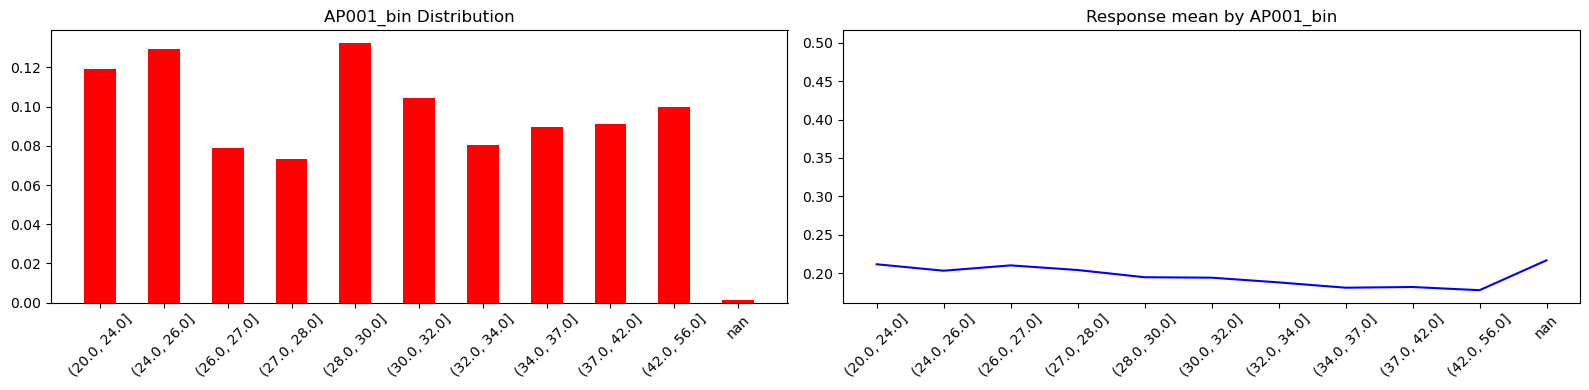

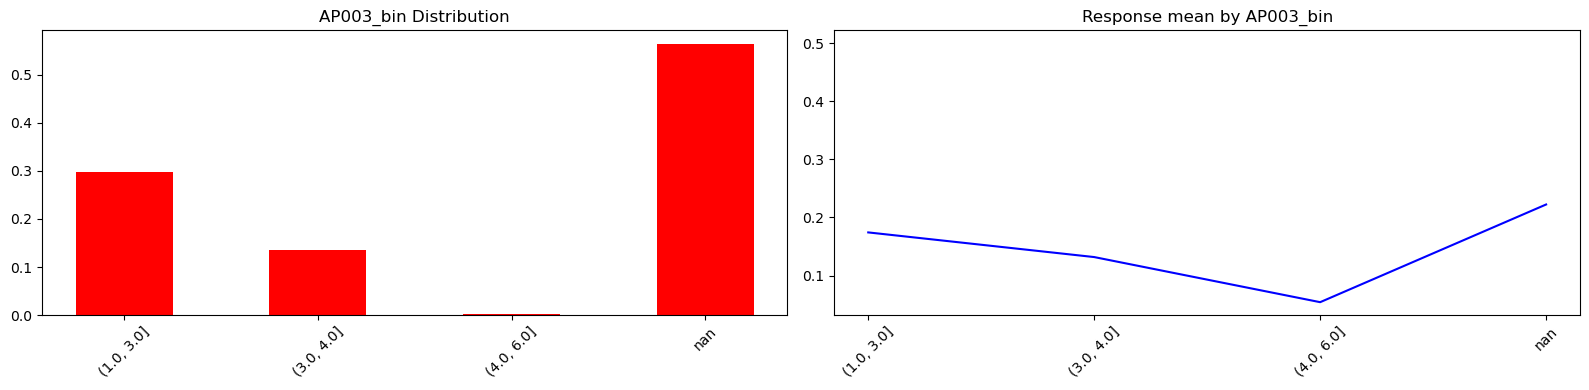

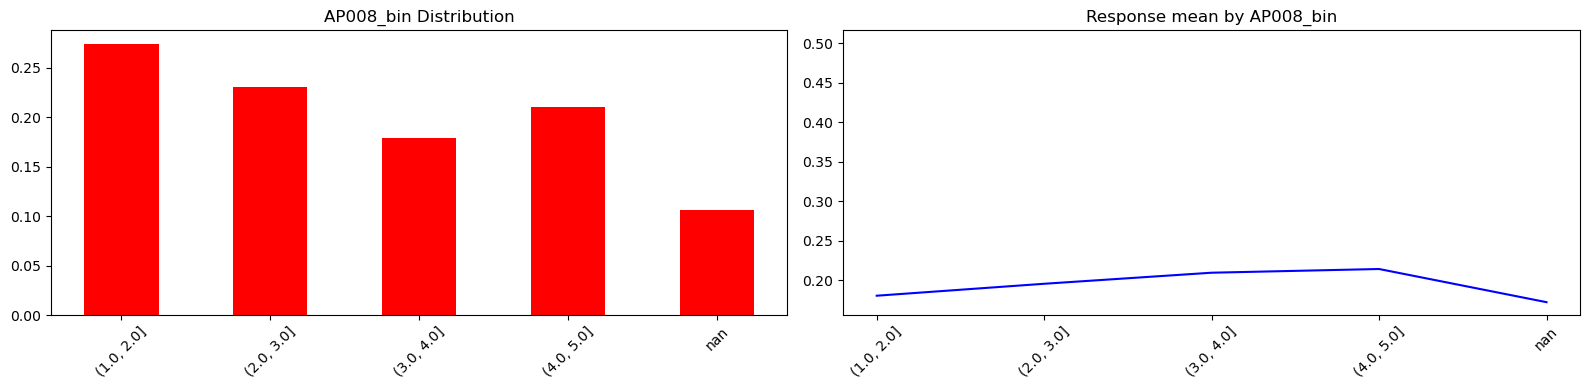

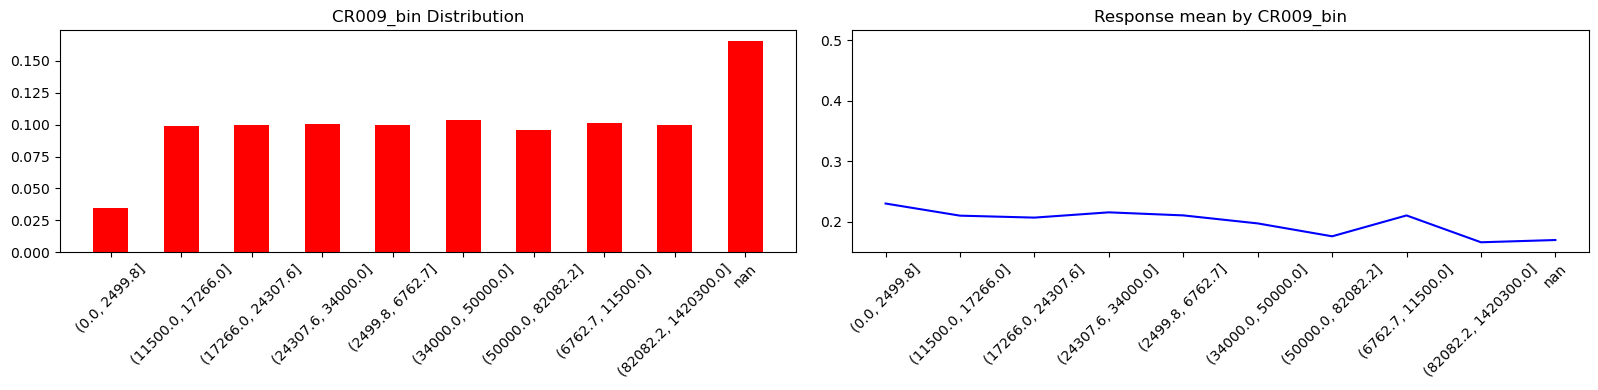

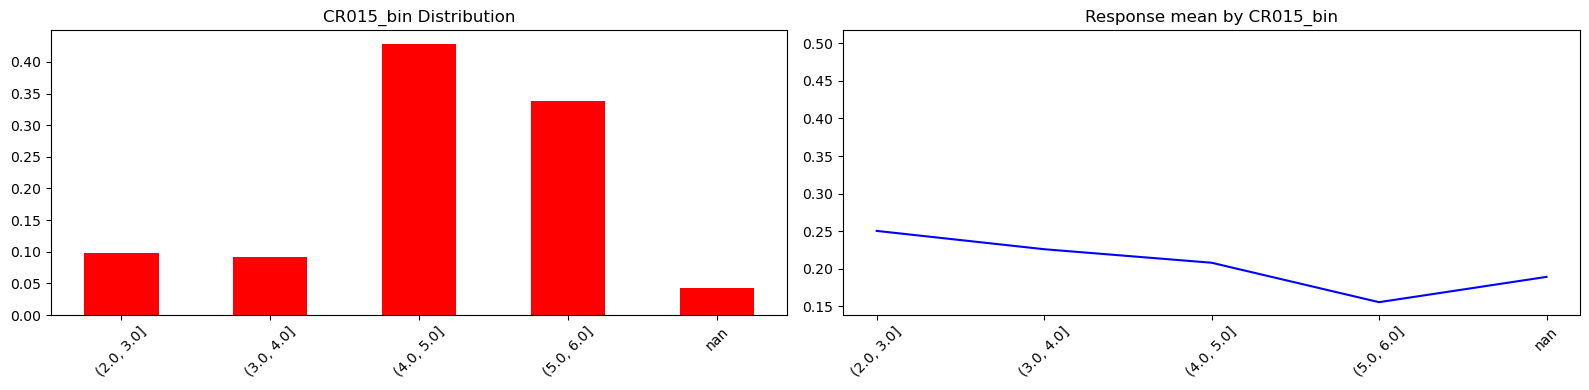

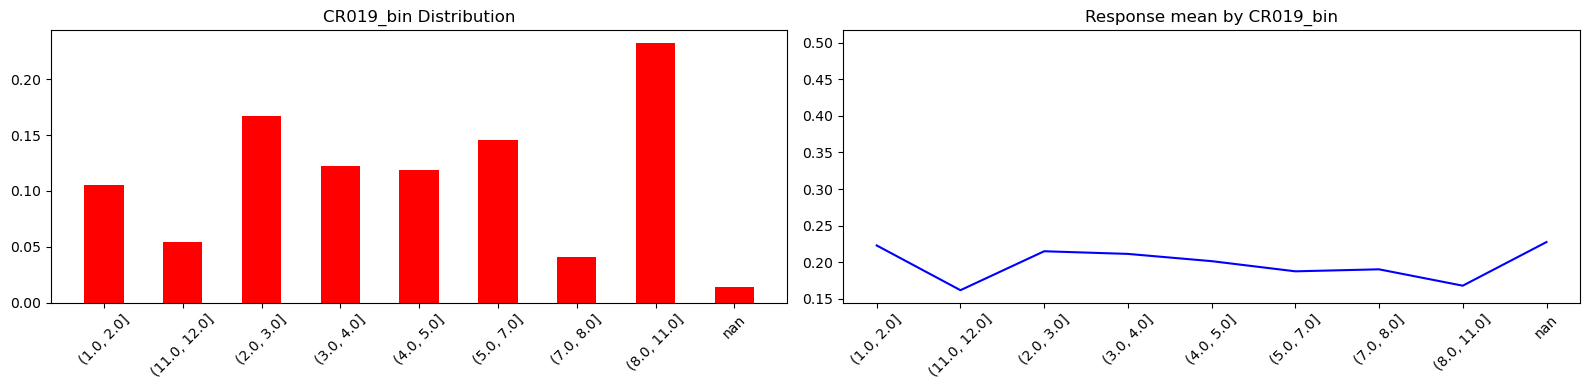

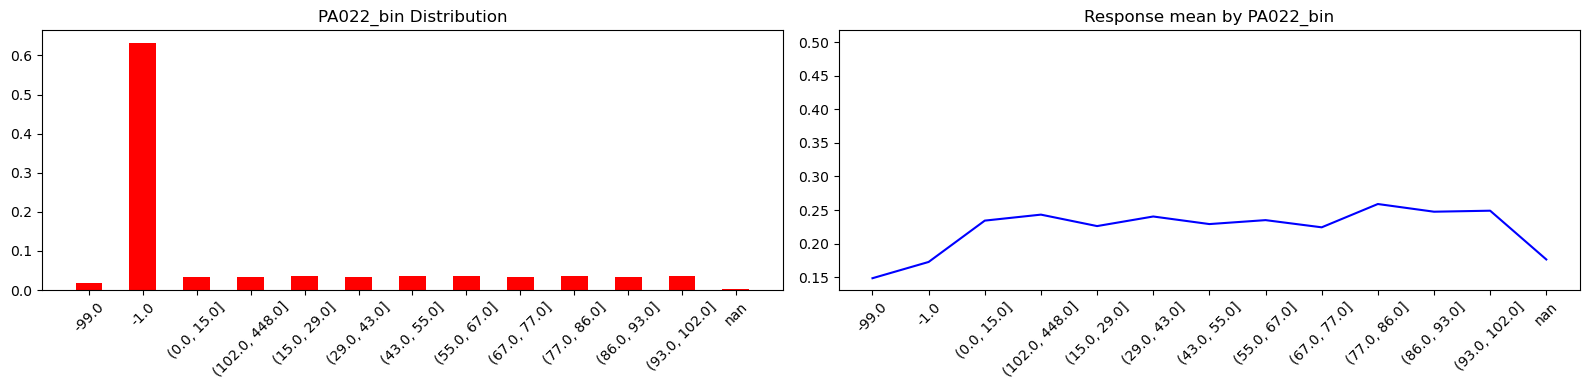

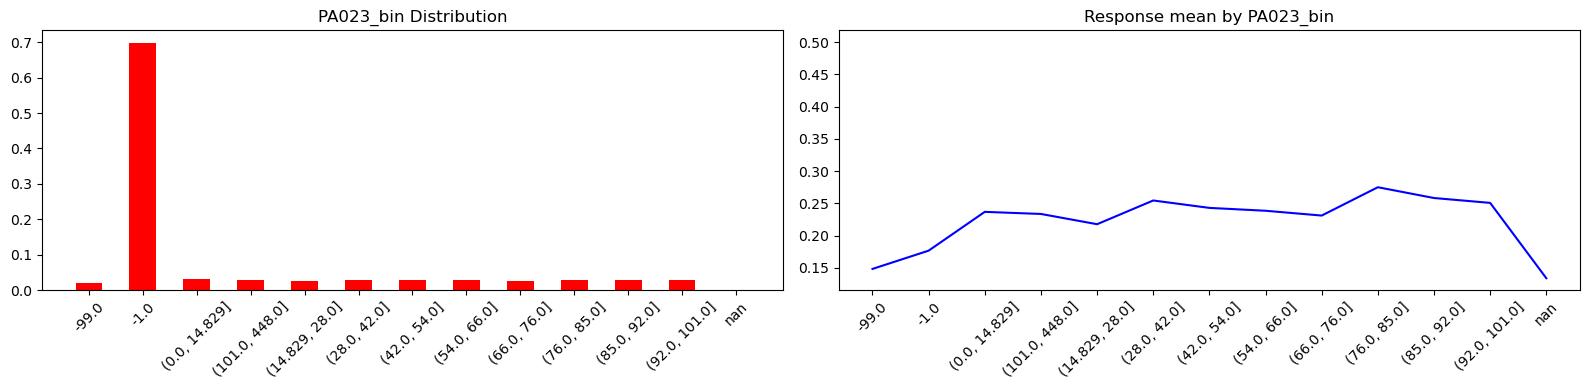

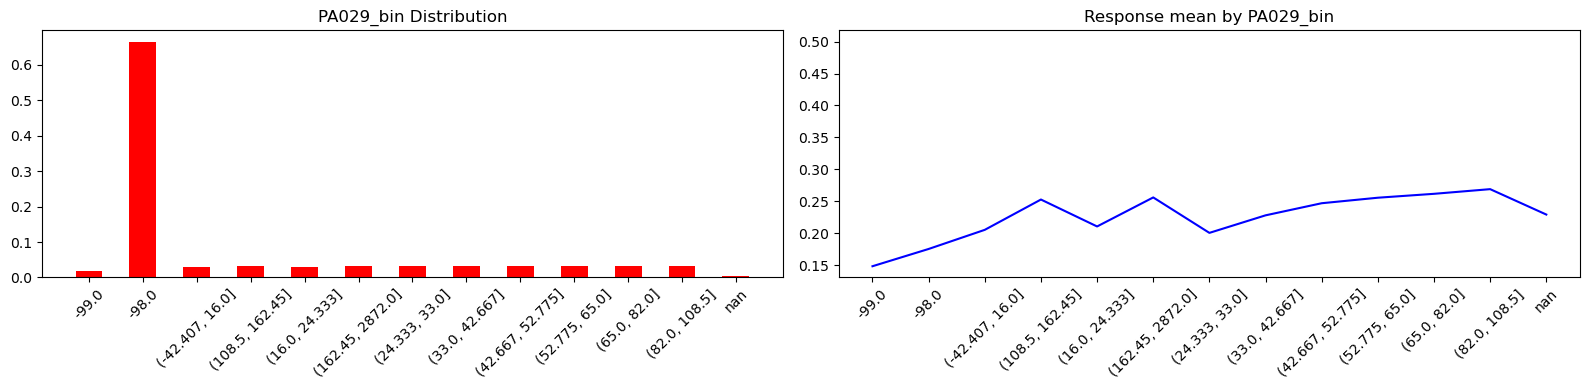

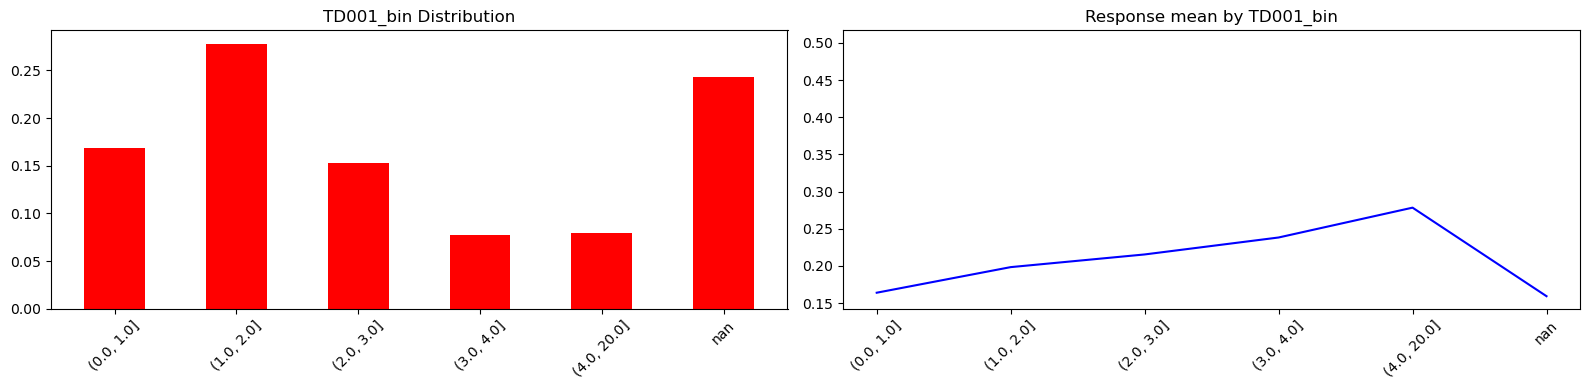

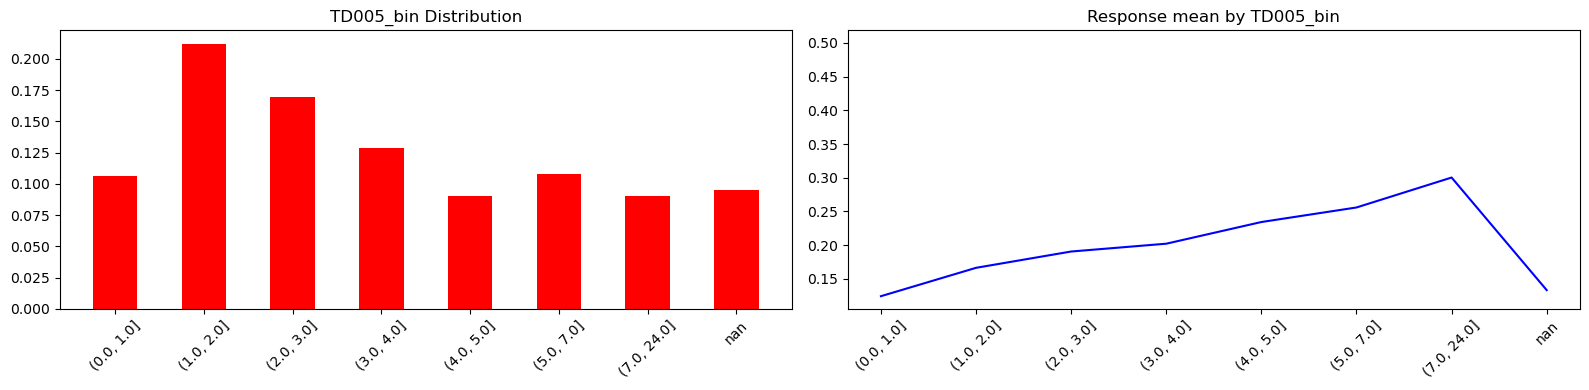

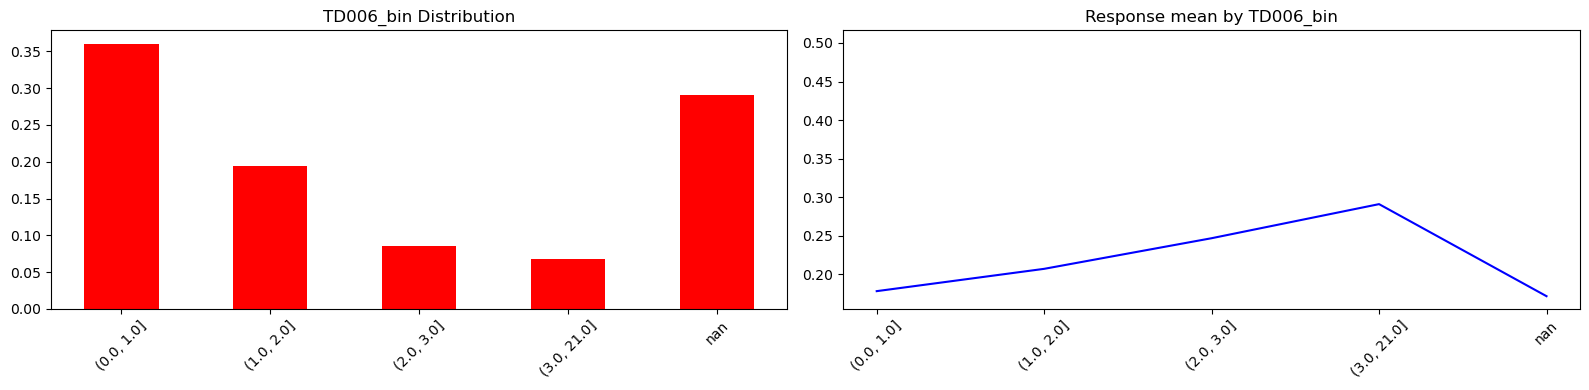

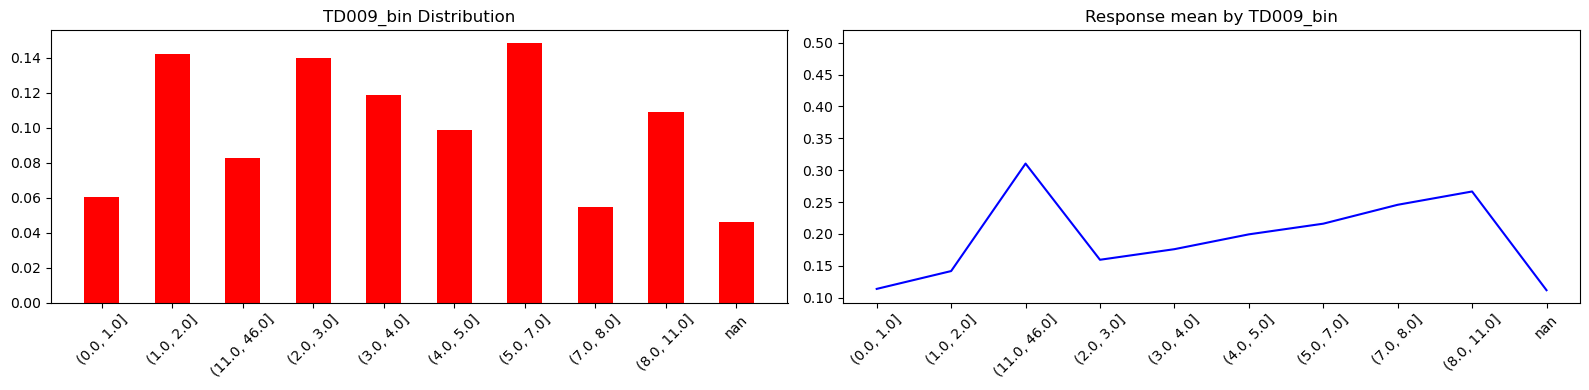

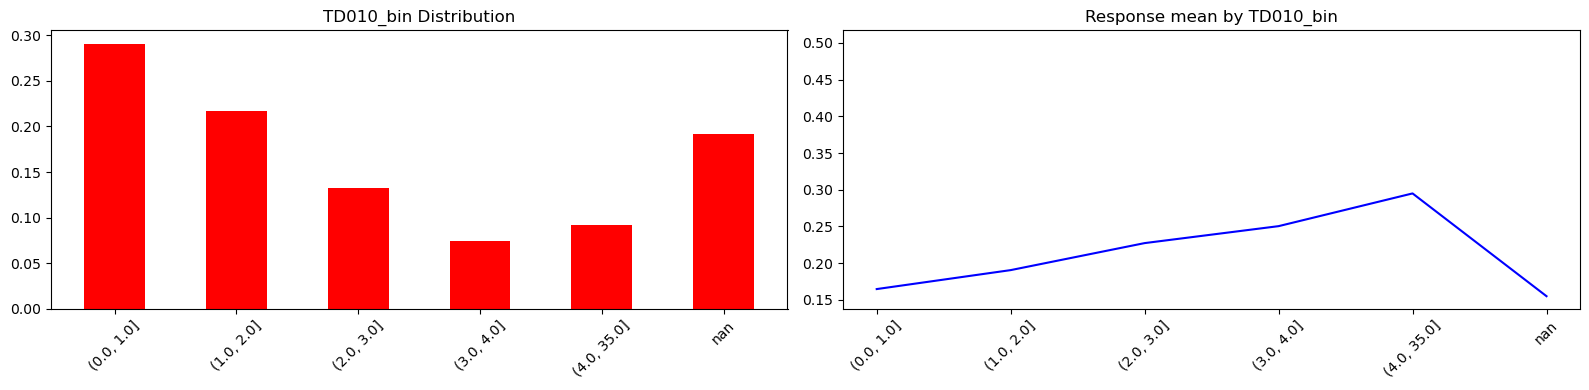

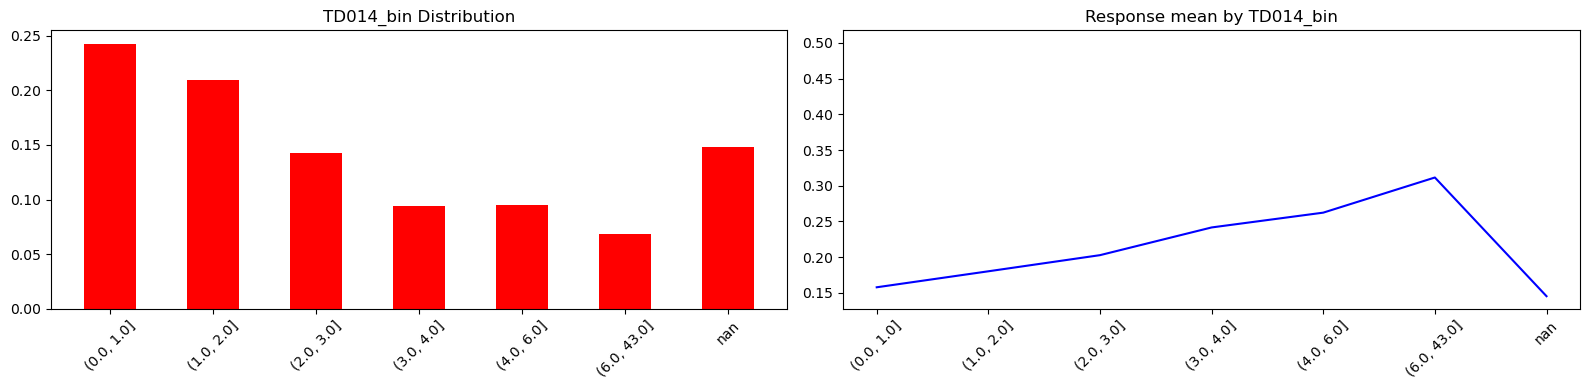

In [55]:
# Show the distribution of the train dataset
def plot_X_and_Y(var):
    z = train.groupby(var)['loan_default'].agg(['count', 'mean']).reset_index() 
    z['count_pcnt'] = z['count']/z['count'].sum()
    x = z[var]
    y_mean = z['mean']
    count_pcnt = z['count_pcnt']
    ind = np.arange(0, len(x))
    width = .5

    fig, axs = plt.subplots(ncols=2, figsize=(16,4))
    axs[0].bar(ind, count_pcnt, width, color='r')
    axs[0].set_title(var + ' Distribution')
    axs[0].set_xticks(ind)
    axs[0].set_xticklabels(x.tolist(), rotation=45)
    
    axs[1].plot(ind, y_mean, width, color='b')
    axs[1].set_title('Response mean by ' + var)
    axs[1].set_xticks(ind)
    axs[1].set_xticklabels(x.tolist(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
for i in features_bin:
    plot_X_and_Y(i) 

### WOE transformation

In [56]:
# Create WOE function
def WOE(var, train):
    train[var] = train[var].fillna('NoData')
    k = train[[var,'loan_default']].groupby(var)['loan_default'].agg(['count','sum']).reset_index()
    k.columns = [var,'Count','Good']
    k['Bad'] = k['Count'] - k['Good']
    k['Good %'] = (k['Good'] / k['Good'].sum()*100).round(2)
    k['Bad %'] = (k['Bad'] / k['Bad'].sum()*100).round(2)
    k[var+'_WOE'] = np.log(k['Good %'] / k['Bad %']).round(2)
    k = k.sort_values(by=var+'_WOE')
    
    return(k)

In [57]:
for f in features_bin:
    try:
        k = WOE(f, train)
        train[f+'_WOE'] = train[f].map(k.set_index(f)[f+'_WOE'])
        train[f+'_WOE'] = train[f+'_WOE'].fillna(k[f+'_WOE'].iloc[-1])
        test[f+'_WOE'] = test[f].map(k.set_index(f)[f+'_WOE'])
        test[f+'_WOE'] = test[f+'_WOE'].fillna(k[f+'_WOE'].iloc[-1])
        #Merge WOE variable from training dataset to test dataset
        test[f+'_WOE'] = test[f+'_WOE'].fillna(train[f+'_WOE'].iloc[-1])
    except:
        pass

### Random Forest with FE

In [58]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [59]:
features_WOE = ['AP001_bin_WOE', 'AP003_bin_WOE', 'AP008_bin_WOE', 'CR009_bin_WOE', 'CR015_bin_WOE', 'CR019_bin_WOE', 'PA022_bin_WOE', 'PA023_bin_WOE', 'PA029_bin_WOE', 'TD001_bin_WOE', 'TD005_bin_WOE', 'TD006_bin_WOE', 'TD009_bin_WOE', 'TD010_bin_WOE', 'TD014_bin_WOE']
target = 'loan_default'

In [60]:
rf_v4 = H2ORandomForestEstimator(
        model_id = 'rf_v4',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v4.train(features_WOE,target,training_frame=train_hex)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v4


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         121059                 7            12           8.55667       24            30            27.29

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.14668234599806154
RMSE: 0.3829913132148842
MAE: 0.2949537468306048
RMSLE: 0.2684979298291319
Mean Residual Deviance: 0.14668234599806154

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.14670974619091684
RMSE: 0.3830270828426064
MAE: 0.2953209254907625
RMSLE: 0.2685492532626149
Mean Residual Deviance: 0.14670974619091684

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.29506    0.00920494  0.299464      0.308245      0.293017      0.305076      0.297101      0.296972      0.288444      0.294195      0.293259      0.27483
mean_residual_deviance  0.146499   0.00900621  0.147597      0.160172      0.139512      0.15486       0.152171      0.150245      0.143032      0.145962      0.143854      0.127588
mse                     0.146499   0.00900621  0.147597      0.160172      0.139512      0.15486       0.152171      0.150245      0.143032      0.145962      0.143854      0.127588
r2                      0.0408631  0.0154731   0.0545976     0.0403692     0.0155129     0.0539588     0.0567781     0.0258978     0.0416267     0.0188127     0.0500488     0.0510281
residual_deviance       0.146499   0.00900621  0.147597      0.160172      0.139512      0.15486       0.152171      0.150245      0.143032      0.145962      0.143854      0.127588
rmse                    0.382586   0.0118886   0.384183      0.400215      0.373513      0.393523      0.390091      0.387615      0.378195      0.382049      0.379281      0.357195
rmsle                   0.268299   0.00643944  0.269056      0.277744      0.265758      0.273601      0.270846      0.271652      0.265145      0.269197      0.266419      0.253574

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-03-22 10:11:48  12.359 sec  0.0                nan                  nan                  nan
     2023-03-22 10:11:48  12.365 sec  1.0                0.38824487753067327  0.2958345183023021   0.15073408492880747
     2023-03-22 10:11:48  12.369 sec  2.0                0.3863475632810352   0.29450870567088144  0.1492644396531935
     2023-03-22 10:11:48  12.372 sec  3.0                0.3874120254135058   0.2948928792063953   0.15008807743499486
     2023-03-22 10:11:48  12.376 sec  4.0                0.38698966592005063  0.29533556369999187  0.1497610015289124
     2023-03-22 10:11:48  12.380 sec  5.0                0.3856723021009273   0.2950544729400433   0.14874312460782893
     2023-03-22 10:11:48  12.384 sec  6.0                0.3846444815471979   0.2956193164238754   0.14795137718471266
     2023-03-22 10:11:48  12.388 sec  7.0                0.3846267929114337   0.29597328771338605  0.1479377698253349
     2023-03-22 10:11:48  12.392 sec  8.0                0.38448478204826714  0.2963836882705056   0.1478285476267035
     2023-03-22 10:

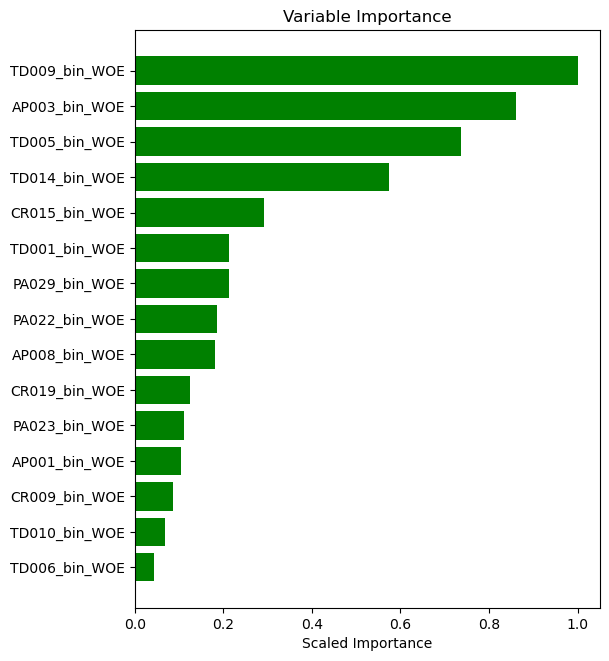

In [61]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()
    
VarImp(rf_v4)

In [62]:
predictions = rf_v4.predict(test_hex)
predictions.head()
test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()
test_scores.head()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,loan_default,predict
0,0,0.188836
1,1,0.319188
2,0,0.112861
3,1,0.150115
4,0,0.106648


In [63]:
# check the lift
createGains(rf_v4)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,200,82,118,200,82,118,0.19,0.07,42.4,1.93,12.0,41.00
1,200,49,151,400,131,269,0.31,0.17,84.8,1.54,14.0,32.75
2,200,59,141,600,190,410,0.45,0.26,127.2,1.49,19.0,31.67
3,200,41,159,800,231,569,0.54,0.36,169.6,1.36,18.0,28.88
4,200,46,154,1000,277,723,0.65,0.46,212.0,1.31,19.0,27.70
5,200,41,159,1200,318,882,0.75,0.56,254.4,1.25,19.0,26.50
6,200,24,176,1400,342,1058,0.81,0.67,296.8,1.15,14.0,24.43
7,200,30,170,1600,372,1228,0.88,0.78,339.2,1.10,10.0,23.25
8,200,34,166,1800,406,1394,0.96,0.88,381.6,1.06,8.0,22.56


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


<AxesSubplot:xlabel='decile'>

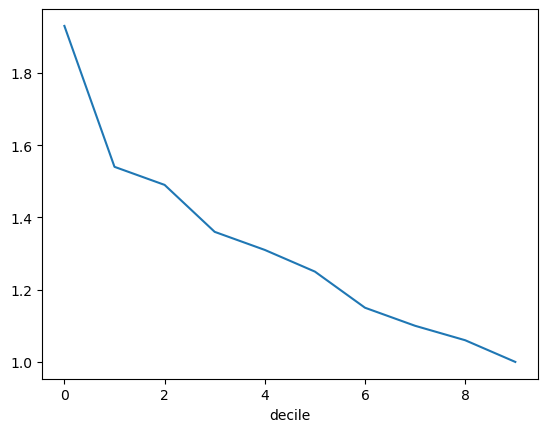

In [64]:
gains = createGains(rf_v4)
gains['lift'].plot.line()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



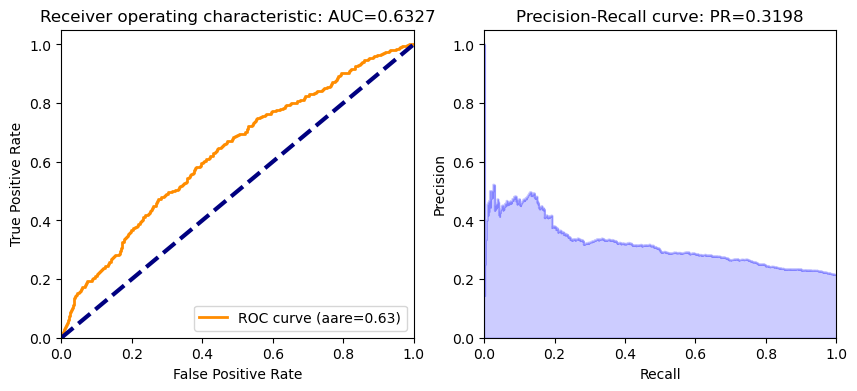

In [65]:
# ROC Curve
ROC_AUC(rf_v4,test_hex,'loan_default')

### RandomUnderSampler with FE

In [66]:
features_WOE = ['AP001_bin_WOE', 'AP003_bin_WOE', 'AP008_bin_WOE', 'CR009_bin_WOE', 'CR015_bin_WOE', 'CR019_bin_WOE', 'PA022_bin_WOE', 'PA023_bin_WOE', 'PA029_bin_WOE', 'TD001_bin_WOE', 'TD005_bin_WOE', 'TD006_bin_WOE', 'TD009_bin_WOE', 'TD010_bin_WOE', 'TD014_bin_WOE']
target = 'loan_default'

In [67]:
y_train = train['loan_default']
y_test = test['loan_default']
x_train = train[features_WOE]
x_test = test[features_WOE]

In [68]:
# RandomUnderSampler
under = RandomUnderSampler(random_state=0, sampling_strategy='auto') 
X_rus, y_rus = under.fit_resample(x_train, y_train)
print('Random undersampling {}'.format(Counter(y_rus)))

Random undersampling Counter({0: 11713, 1: 11713})


In [69]:
smpl_rus = pd.concat([X_rus,y_rus], axis=1)
smpl_hex_rus = h2o.H2OFrame(smpl_rus)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [70]:
rf_v5 = H2ORandomForestEstimator(
        model_id = 'rf_v5',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v5.train(features_WOE,target,training_frame=smpl_hex_rus)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v5


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         416802                 10           15           11.59         100           114           105.84

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.23213937045964472
RMSE: 0.4818084375139613
MAE: 0.46735436125058233
RMSLE: 0.33863804482133486
Mean Residual Deviance: 0.23213937045964472

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.23234881782776753
RMSE: 0.4820257439471128
MAE: 0.46779520243921213
RMSLE: 0.3387986384317135
Mean Residual Deviance: 0.23234881782776753

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.46779    0.00148397  0.467365      0.469229      0.468299      0.466733      0.468856      0.470361      0.466434      0.467381      0.465259      0.467982
mean_residual_deviance  0.232345   0.00159247  0.231917      0.234318      0.232538      0.231004      0.232877      0.235239      0.23111       0.23202       0.229789      0.232642
mse                     0.232345   0.00159247  0.231917      0.234318      0.232538      0.231004      0.232877      0.235239      0.23111       0.23202       0.229789      0.232642
r2                      0.0697831  0.00688145  0.072314      0.0614141     0.0694271     0.0758408     0.065414      0.0582909     0.0755534     0.0718075     0.0806197     0.0671494
residual_deviance       0.232345   0.00159247  0.231917      0.234318      0.232538      0.231004      0.232877      0.235239      0.23111       0.23202       0.229789      0.232642
rmse                    0.48202    0.00165103  0.481578      0.484064      0.482222      0.480628      0.482574      0.485014      0.480739      0.481684      0.479363      0.482329
rmsle                   0.338796   0.00215004  0.338972      0.342012      0.340042      0.337285      0.336221      0.342251      0.337875      0.33933       0.337745      0.336229

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-03-22 10:12:25  32.749 sec  0.0                nan                  nan                  nan
     2023-03-22 10:12:25  32.761 sec  1.0                0.48793412670439723  0.4677252577152487   0.23807971200278275
     2023-03-22 10:12:25  32.772 sec  2.0                0.48709564257107096  0.46688302080583466  0.23726216501172454
     2023-03-22 10:12:25  32.784 sec  3.0                0.486965034379118    0.4672608372498626   0.23713494470785554
     2023-03-22 10:12:25  32.797 sec  4.0                0.4861173388010299   0.4669274818342807   0.23631006708299532
     2023-03-22 10:12:25  32.810 sec  5.0                0.485599709984934    0.46660127562294595  0.23580707833745201
     2023-03-22 10:12:25  32.823 sec  6.0                0.4853023496639939   0.46679539249599394  0.23551837058939337
     2023-03-22 10:12:25  32.837 sec  7.0                0.4847395083247936   0.46678888780229055  0.23497239093096267
     2023-03-22 10:12:25  32.850 sec  8.0                0.48463770193472105  0.46699182328054406  0.23487370213656752
     2023-

In [71]:
# check the lift
createGains(rf_v5)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,200,82,118,200,82,118,0.19,0.07,42.4,1.93,12.0,41.00
1,200,54,146,400,136,264,0.32,0.17,84.8,1.60,15.0,34.00
2,200,50,150,600,186,414,0.44,0.26,127.2,1.46,18.0,31.00
3,200,48,152,800,234,566,0.55,0.36,169.6,1.38,19.0,29.25
4,200,45,155,1000,279,721,0.66,0.46,212.0,1.32,20.0,27.90
5,200,37,163,1200,316,884,0.75,0.56,254.4,1.24,19.0,26.33
6,200,35,165,1400,351,1049,0.83,0.67,296.8,1.18,16.0,25.07
7,200,29,171,1600,380,1220,0.90,0.77,339.2,1.12,13.0,23.75
8,200,28,172,1800,408,1392,0.96,0.88,381.6,1.07,8.0,22.67


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


<AxesSubplot:xlabel='decile'>

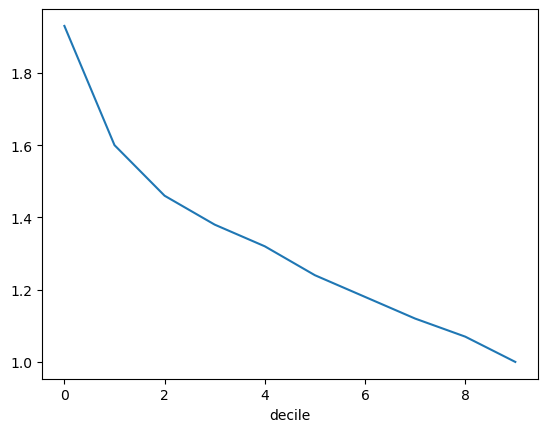

In [72]:
gains = createGains(rf_v5)
gains['lift'].plot.line()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



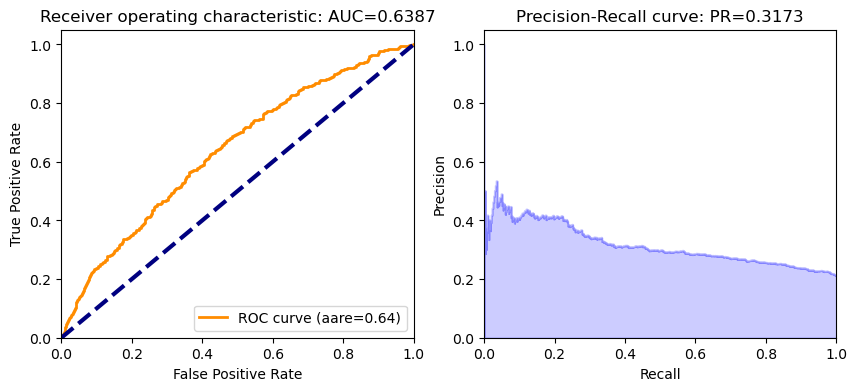

In [73]:
# ROC Curve
ROC_AUC(rf_v5,test_hex,'loan_default')

### ClusterCentroids with FE

In [74]:
# ClusterCentroids
sampler = ClusterCentroids(random_state=0, sampling_strategy='auto') 
X_rus, y_rus = under.fit_resample(x_train, y_train)
print('Cluster centriods undersampling {}'.format(Counter(y_rus)))

Cluster centriods undersampling Counter({0: 11713, 1: 11713})


In [75]:
smpl_rus = pd.concat([X_rus,y_rus], axis=1)
smpl_hex_rus = h2o.H2OFrame(smpl_rus)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [76]:
rf_v6 = H2ORandomForestEstimator(
        model_id = 'rf_v6',
        ntrees = 300,
        nfolds=10,
        min_rows=100,
        seed=1234)
rf_v6.train(features_WOE,target,training_frame=smpl_hex_rus)

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2ORandomForestEstimator : Distributed Random Forest
Model Key: rf_v6


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    300                300                         416801                 10           15           11.59         100           114           105.84

ModelMetricsRegression: drf
** Reported on train data. **

MSE: 0.23213937045964472
RMSE: 0.4818084375139613
MAE: 0.46735436125058233
RMSLE: 0.33863804482133486
Mean Residual Deviance: 0.23213937045964472

ModelMetricsRegression: drf
** Reported on cross-validation data. **

MSE: 0.23234881782776753
RMSE: 0.4820257439471128
MAE: 0.46779520243921213
RMSLE: 0.3387986384317135
Mean Residual Deviance: 0.23234881782776753

Cross-Validation Metrics Summary: 
                        mean       sd          cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid    cv_6_valid    cv_7_valid    cv_8_valid    cv_9_valid    cv_10_valid
----------------------  ---------  ----------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------
mae                     0.46779    0.00148397  0.467365      0.469229      0.468299      0.466733      0.468856      0.470361      0.466434      0.467381      0.465259      0.467982
mean_residual_deviance  0.232345   0.00159247  0.231917      0.234318      0.232538      0.231004      0.232877      0.235239      0.23111       0.23202       0.229789      0.232642
mse                     0.232345   0.00159247  0.231917      0.234318      0.232538      0.231004      0.232877      0.235239      0.23111       0.23202       0.229789      0.232642
r2                      0.0697831  0.00688145  0.072314      0.0614141     0.0694271     0.0758408     0.065414      0.0582909     0.0755534     0.0718075     0.0806197     0.0671494
residual_deviance       0.232345   0.00159247  0.231917      0.234318      0.232538      0.231004      0.232877      0.235239      0.23111       0.23202       0.229789      0.232642
rmse                    0.48202    0.00165103  0.481578      0.484064      0.482222      0.480628      0.482574      0.485014      0.480739      0.481684      0.479363      0.482329
rmsle                   0.338796   0.00215004  0.338972      0.342012      0.340042      0.337285      0.336221      0.342251      0.337875      0.33933       0.337745      0.336229

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse        training_mae         training_deviance
---  -------------------  ----------  -----------------  -------------------  -------------------  -------------------
     2023-03-22 10:13:06  34.586 sec  0.0                nan                  nan                  nan
     2023-03-22 10:13:06  34.597 sec  1.0                0.48793412670439723  0.4677252577152487   0.23807971200278275
     2023-03-22 10:13:06  34.606 sec  2.0                0.48709564257107096  0.46688302080583466  0.23726216501172454
     2023-03-22 10:13:06  34.615 sec  3.0                0.486965034379118    0.4672608372498626   0.23713494470785554
     2023-03-22 10:13:06  34.625 sec  4.0                0.4861173388010299   0.4669274818342807   0.23631006708299532
     2023-03-22 10:13:06  34.635 sec  5.0                0.485599709984934    0.46660127562294595  0.23580707833745201
     2023-03-22 10:13:06  34.646 sec  6.0                0.4853023496639939   0.46679539249599394  0.23551837058939337
     2023-03-22 10:13:06  34.658 sec  7.0                0.4847395083247936   0.46678888780229055  0.23497239093096267
     2023-03-22 10:13:06  34.669 sec  8.0                0.48463770193472105  0.46699182328054406  0.23487370213656752
     2023-

In [77]:
# check the lift
createGains(rf_v6)

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,200,82,118,200,82,118,0.19,0.07,42.4,1.93,12.0,41.00
1,200,54,146,400,136,264,0.32,0.17,84.8,1.60,15.0,34.00
2,200,50,150,600,186,414,0.44,0.26,127.2,1.46,18.0,31.00
3,200,48,152,800,234,566,0.55,0.36,169.6,1.38,19.0,29.25
4,200,45,155,1000,279,721,0.66,0.46,212.0,1.32,20.0,27.90
5,200,37,163,1200,316,884,0.75,0.56,254.4,1.24,19.0,26.33
6,200,35,165,1400,351,1049,0.83,0.67,296.8,1.18,16.0,25.07
7,200,29,171,1600,380,1220,0.90,0.77,339.2,1.12,13.0,23.75
8,200,28,172,1800,408,1392,0.96,0.88,381.6,1.07,8.0,22.67


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


<AxesSubplot:xlabel='decile'>

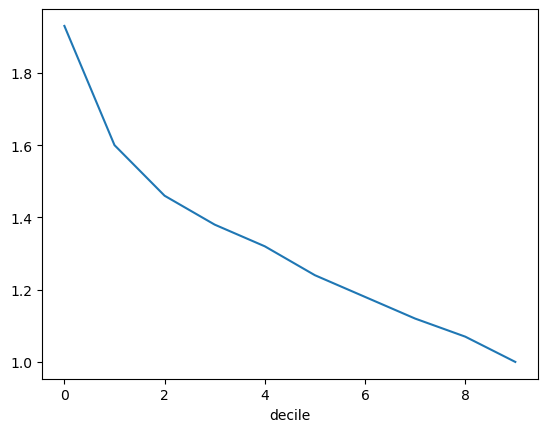

In [78]:
gains = createGains(rf_v6)
gains['lift'].plot.line()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

   * ROC curve: The ROC curve plots the true positive rate vs. the false rositive sate

	  * The area under the curve (AUC): A value between 0.5 (random) and 1.0 (perfect), measuring the prediction accuracy

   * Recall (R) = The number of true positives / (the number of true positives + the number of false negatives)



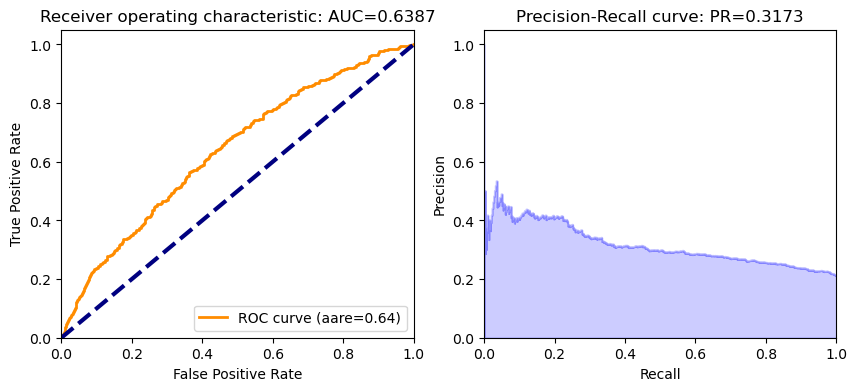

In [79]:
# ROC Curve
ROC_AUC(rf_v6,test_hex,'loan_default')

# Section 6: Conclusion

The aim of this data analysis is to develop supervisied ML models that can identify anomalies or loans with a high potential for default. The model employs 15 features, with "loan_default" serving as the target variable. 3 supervised ML models of H20 Random Forest, Random undersampling and ClusterCentroids were created: one utilizing the raw features, and the other implementing feature engineering (FE) techniques including binning and WOE transformation. This approach allows for an assessment of the impact of FE on improving model accuracy and performance.

### ROC  
1. H20 Random Forest 
* Raw Features : AUC = 0.6346, PR = 0.2762
* With WOE FE : AUC = 0.6327, PR = 0.3198

2. Undersampling - Random undersampling 
* Raw Features : AUC = 0.6740, PR = 0.6637
* With WOE FE : AUC = 0.6387, PR = 0.3173

3. Undersampling - ClusterCentroids
* Raw Features : AUC = 0.6740, PR = 0.6637
* With WOE FE : AUC = 0.6387, PR = 0.3173

The AUC score is a measure of a model's ability to distinguish between positive and negative cases, with a higher score indicating better performance. The best performing model based on ROC score was the undersampling model with raw features, with an AUC score of 0.6740 and a PR score of 0.6637.

### Cumulative Lift 
The cumulative lift is a metric that compares the model's results with and without the model to assess its performance. The lift score shows how many times better the model performs compared to the baseline model. From the gain tables above, it shows that the cumulative lift score of the undersampling model with FE is higher than other models, it indicates that the undersampling model with FE is performing better than the other models. This means that the undersampling model with FE is able to identify the positive cases more efficiently than the other models.

Overall, undersampling models may be a better approach than H20 Random Forest model when dealing with imbalanced datasets, meaning that the proportion of loan defaults to non-defaults was skewed. In such cases, because undersampling techniques such as Random Under-Sampling and ClusterCentroids directly addresses the issue of class imbalance. 

The choice of performance metrics such as ROC and Precision-Recall can affect the evaluation of classifiers, especially in imbalanced datasets where the minority class is of interest. ROC prioritizes the true positive rate (TPR) and false positive rate (FPR) equally and may not reflect the actual performance of the classifier on the minority class. Precision-Recall, on the other hand, emphasizes the precision (positive predictive value) and recall (sensitivity) of the classifier, which can be more informative in identifying rare events.

The effectiveness of feature engineering depends on the quality and relevance of the features, as well as the complexity and non-linearity of the problem. In some cases, raw features may be sufficient to achieve good performance, while in others, feature engineering may be necessary to extract meaningful patterns and reduce noise. Therefore, it is important to explore different feature sets and compare their performance to determine the best approach.

In summary, the undersampling models performed the best in identifying high-risk loans or potential defaults. However, feature engineering may not improve the model accuracy, likely because the dataset was not highly imbalanced.